In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [133]:
# GBM parameters
M0 = 100.0
sigma = 1.0
T = 1.0/365.25/24 # this the year fraction corresponding to one hour
N = 3600 # place one order per second (as long as T above is one hour)

numMCSamples = 10000 # so we can consider some stats 

muHat = -0.5*sigma*sigma*T
sigmaHat = np.sqrt(N*T)*sigma

print("1 + muHat = "+str(1 + muHat))
print("sigma = "+str(sigma))

timeGrid = np.linspace(0,T,N)
priceLevels = np.zeros([numMCSamples,N])
priceLevels[:,0] = M0

1 + muHat = 0.9999429614419347
sigma = 1.0


Simplest case: we generate the shocks as normal r.v. that's just an initial sanity check

In [134]:
shocksX = np.random.normal(muHat, sigmaHat,(numMCSamples,N))

for i in range(0,N-1):
    Y = np.exp(shocksX[:,i]/N)
    priceLevels[:,i+1] = priceLevels[:,i]*Y

In [135]:
priceRatio = priceLevels[:,N-1]/priceLevels[:,0]
print("mean = %.3f" % np.mean(priceRatio))
sampleSigma = np.sqrt(np.var(priceRatio)/T)
print('sample stddev = %.3f, wanted sigma= %.3f' % (sampleSigma, sigma))

mean = 1.000
sample stddev = 1.003, wanted sigma= 1.000


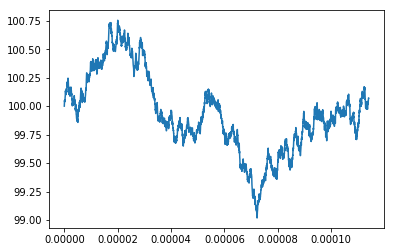

In [136]:
plt.plot(timeGrid, priceLevels[0,:])
plt.show()

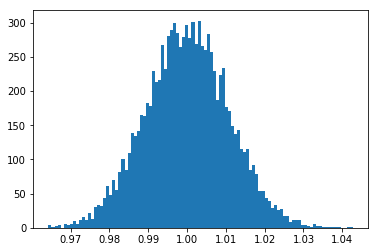

In [137]:
plt.hist(priceRatio, bins=100)
plt.show()

What happens if we try to round to discrete price levels?

mean = 1.000
sample stddev = 0.394, wanted sigma= 1.000


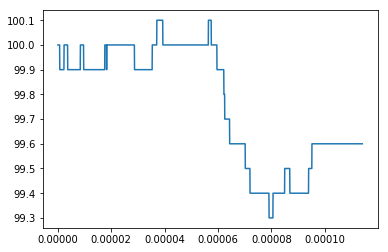

In [138]:
shocksX = np.random.normal(muHat, sigmaHat,(numMCSamples,N))

for i in range(0,N-1):
    Y = np.exp(shocksX[:,i]/N)
    priceLevels[:,i+1] = np.round(priceLevels[:,i]*Y,1)
    
priceRatio = priceLevels[:,N-1]/priceLevels[:,0]
print("mean = %.3f" % np.mean(priceRatio))
sampleSigma = np.sqrt(np.var(priceRatio)/T)
print('sample stddev = %.3f, wanted sigma= %.3f' % (sampleSigma, sigma))

plt.plot(timeGrid, priceLevels[0,:])
plt.show()


So we cannot deal with discrete prices by simply rounding / bucketing as that's reducing the desired volatility.

Now let's be a bit more funky and ensure we only move by the tick size while maintaining the correct variance.



In [139]:
delta = 0.2

V = np.array([N*np.log((M0-delta)/M0),0.0,N*np.log((M0+delta)/M0)])
Vsq = V*V
matA = np.stack((V,Vsq,np.ones(3)))
#print(matA)
b = np.array([muHat,sigmaHat**2+muHat**2,1])
#print(b)

# probabilities = np.linalg.solve(matA,b)
#probabilities[0] = 1-np.sum(probabilities[1:3])
fun = lambda p: np.linalg.norm(np.dot(matA,p)-b) 
sol = minimize(fun, np.zeros(3), method='L-BFGS-B', bounds=[(0.,None) for x in range(3)])
probabilities = sol['x']/np.sum(sol['x']) # so they sum up to 1
print(probabilities)


shocksX = np.random.choice(V, (numMCSamples,N), p=probabilities)
for i in range(0,N-1):
    Y = np.exp(shocksX[:,i]/N)
    priceLevels[:,i+1] = np.round(priceLevels[:,i]*Y,3)
    
priceRatio = priceLevels[:,N-1]/priceLevels[:,0]
print("mean = %.3f" % np.mean(priceRatio))
sampleSigma = np.sqrt(np.var(priceRatio)/T)
print('sample stddev = %.3f, wanted sigma= %.3f' % (sampleSigma, sigma))




[0.00396099 0.99207801 0.003961  ]
mean = 1.000
sample stddev = 0.992, wanted sigma= 1.000


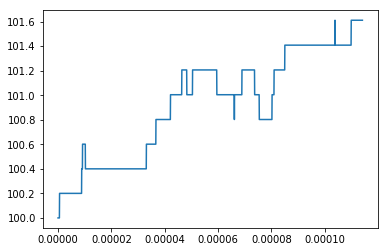

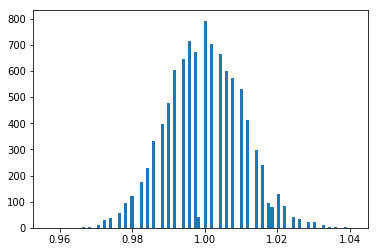

In [140]:
plt.plot(timeGrid, priceLevels[5,:])
plt.show()

plt.hist(priceRatio, bins=100)
plt.show()

In [10]:
# Another test

# GBM parameters
M0 = 100.0
sigma = 1.0
T = 1.0/365.25/24/60 # this the year fraction corresponding to one minute
N = 10 # place N orders per T

numMCSamples = 10000 # so we can consider some stats 

muHat = -0.5*sigma*sigma*T
sigmaHat = np.sqrt(N*T)*sigma

print("1 + muHat = "+str(1 + muHat))
print("sigma = "+str(sigma))

timeGrid = np.linspace(0,T,N)
priceLevels = np.zeros([numMCSamples,N])
priceLevels[:,0] = M0

1 + muHat = 0.9999990493573656
sigma = 1.0


[0.33339361 0.33323706 0.33336932]
mean = 1.000
sample stddev = 0.888, wanted sigma= 1.000


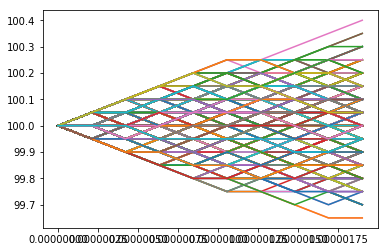

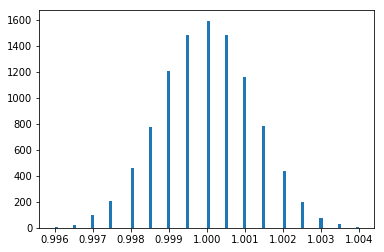

In [14]:
delta = 0.05

V = np.array([N*np.log((M0-delta)/M0),0.0,N*np.log((M0+delta)/M0)])
Vsq = V*V
matA = np.stack((V,Vsq,np.ones(3)))
#print(matA)
b = np.array([muHat,sigmaHat**2+muHat**2,1])
#print(b)

# probabilities = np.linalg.solve(matA,b)
#probabilities[0] = 1-np.sum(probabilities[1:3])
fun = lambda p: np.linalg.norm(np.dot(matA,p)-b) 
sol = minimize(fun, np.zeros(3), method='L-BFGS-B', bounds=[(0.,None) for x in range(3)])
probabilities = sol['x']/np.sum(sol['x']) # so they sum up to 1
print(probabilities)


shocksX = np.random.choice(V, (numMCSamples,N), p=probabilities)
for i in range(0,N-1):
    Y = np.exp(shocksX[:,i]/N)
    priceLevels[:,i+1] = np.round(priceLevels[:,i]*Y,3)
    
priceRatio = priceLevels[:,N-1]/priceLevels[:,0]
print("mean = %.3f" % np.mean(priceRatio))
sampleSigma = np.sqrt(np.var(priceRatio)/T)
print('sample stddev = %.3f, wanted sigma= %.3f' % (sampleSigma, sigma))



for i in range(0,1000):
    plt.plot(timeGrid, priceLevels[i,:])
plt.show()

plt.hist(priceRatio, bins=100)
plt.show()